首先，我要非常感谢 Optiver 和 Kaggle 组织了一场非常有趣的比赛。 我以前从未分析过财务数据，但是感谢非常有用的教程笔记本，我能够完全沉浸在比赛中。

我不知道我在最终排行榜上的排名，但我的公共第二名解决方案的要点如下：

通过时间ID顺序的逆向工程进行时间序列交叉验证

最近邻聚合特征（从 0.21 提升到 0.19）

LightGBM、MLP 和 MoA 的 1D-CNN 的混合

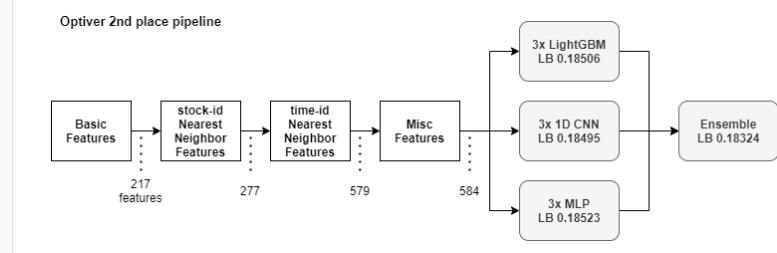

# time-id顺序的逆向工程

1、竞争数据中的价格是标准化的，但正如有人在讨论中指出的那样，您可以使用“tick size”来恢复标准化之前的真实价格。

2、此外，通过使用 t-SNE 将 time-id x stock-id 价格矩阵压缩为一维，我能够以足够的准确度恢复 time-id 的顺序。

训练数据的time-id顺序恢复的正确性可以通过与真实市场数据的对比来轻松验证。 通过这样做，我们知道训练数据是 2020/1/1~2021/3/31 之间的时间段。

时间序列交叉验证。 现在我们知道时间戳的正确顺序，我们可以构建验证集，就好像它们是正常的时间序列数据一样。

检测协变量变化。 使用对抗性验证等方法使我们能够找到随时间变化的特征。

数据排除。 我没有这样做是因为它对我不起作用，但我们可以从我们的数据中排除特定市场事件的时期，例如 2020 年初的股市崩盘。

时间序列的交叉验证尤其重要。我使用了4折时间序列的交叉验证，每折使用10%的数据进行验证。 
这让我在整个比赛中获得了 CV 和 LB 之间足够好的（尽管不是完美的）相关性。

# 数据是如何产生的？

顺便说一句，在 2020/1/1~2021/3/31 之间，股市开市 443 天，期间共有 3833 个 time-id，
也就是说每天大约记录了 8.6 个 time-id。

如果Optiver排除（由于某种原因，可能很难预测）股市开市时间的第一个小时和最后一个小时，
那么10:30~15:00的时间可以用于竞争数据。 如果他们将这个时间段划分为 30 分钟的间隔，
那么每天将记录多达 9 个时间 ID。

实际上，考虑到断路器和提前关闭的日子，他们可以用于数据的时间 ID 的数量应该略少于每天 9 个。 
这只是一个猜测，但我认为这就是数据的生成方式。

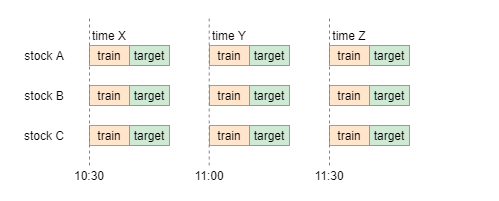

# 特征工程

在这场根据前 10 分钟数据预测未来 10 分钟实际波动率（RV）的竞赛中，最重要的特征显然是前 10 分钟的 RV。

但是，如果我们考虑数据是如何生成的，就在 time-id 的目标计算周期后 10 分钟，下一个 time-id 的训练数据开始。这意味着如果time-id的顺序可以完全恢复，我们可以期待下一个time-id的RV是一个非常强大的特性。

如果我们进一步泛化，我们不仅可以使用下一个时间标识，还可以使用在某个距离度量中“相似”的时间标识信息来提高预测精度。例如，当市场具有相似的价格、波动性和交易量时，同一股票的 RV 将有助于预测某个时间 id 的 RV。

因此，我使用具有各种距离指标的 NearestNeighbor 来查找相似的 N 个时间 ID，并计算 RV 和库存大小（N=2、3、5、10、20、40）等特征的平均值。

除了时间 ID，我还计算了相似股票 ID 之间的聚合。此外，通过结合这些想法，我计算了诸如“在 5 个最接近的时间 ID 中具有相似波动性的 20 只相似股票的平均 tau”等特征。

我总共创建了大约 600 个特征，其中 360 个是最近邻特征，而我的大部分分数提升都是基于这些 NN 特征。

我不认为我们可以在真实的 Optiver 场景中使用未来信息，
但是使用最近邻聚合附近特征的想法可能可以在真实模型中使用。

# 特征处理

现在我们知道了 time-id 的顺序，我们可以检测随时间变化的特征。 通过执行对抗验证，我注意到从 trade.order_count 和 book.total_volume 聚合的特征随着时间的推移发生了显着变化。 因此，我没有使用它们的原始特征，而是将这些特征转换为同一时间 ID 内的等级。

我还将 np.log1p 应用于具有大偏斜的特征，因为如果在第二阶段出现大的异常值，它们可能会降低预测。

这些在 LB 分数上几乎没有改善，但我相信它们有助于降低私人 LB 的风险。

没有用的工作

很多特定领域的特征，比如 beta 系数
TabNet（还不错，但训练时间太长）
在残差上训练 NN（目标 - book.log_return.realized_volatility）
降维特征

我认为可能有效的工作，但没有时间做的

300 秒模型（将训练数据分为前半部分和后半部分，并创建一个模型，从前半部分预测后半部分的 RV 并将其用作元特征或数据增强）
具有不创建特征的 LSTM 和 RNN 的集成
自动编码器